<a href="https://colab.research.google.com/github/AnastasiaBrinati/Calcolatrice21-22/blob/master/training_routine_ufficiale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My\ Drive/ProgettoMOBD

In [4]:
import sklearn
import pandas as pd
import numpy as np

from numpy import array
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree

#serialization
from joblib import dump
from sklearn.pipeline import Pipeline
import pickle
import dill

#graphs
import graphviz
import matplotlib.pyplot as plt

#evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

np.random.seed = 123457

In [ ]:
# LETTURA DATASET
data = pd.read_csv("train.csv", sep=",")
print(data.head())

In [ ]:
# print("\nLabels: {}".format(np.unique(data.Y, return_counts=True)))
# print("\n# of NaNs values for each column:")
# print(data.isnull().sum(axis=0))

# dropping nan values: lowers the performance of circa 10%
# data = data.dropna()

x = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
# print(x.shape)
# print(y.shape)

# stratify: to mantain the same mean as y for y_tr and y_ts
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.24, random_state=258, stratify=y)

print(np.unique(y, return_counts=True)[1]/len(y))
print(np.unique(y_tr, return_counts=True)[1]/len(y_tr))
print(np.unique(y_ts, return_counts=True)[1]/len(y_ts))

In [77]:
# sostituzione valori nan: dato che sono presenti valori categorici, e nello specifico sono proprio
# tre colonne di quel tipo ad avere valori mancanti, abbiamo optato per un semplice Imputer 
# che sostituisse con i più frequenti.

imputer = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
x_tr_notnan = imputer.fit_transform(x_tr)
# la sostituzione sul test set avviene con il most_frequent calcolato sul training set
x_ts_notnan = imputer.transform(x_ts)

In [98]:
# one hot code: stiamo rimpiazzando ogni colonna corrispondente ad un attributo categorico
# con un set di colonne della cardinalità del range dell'attributo in questione, 
# a ciascuna delle quali corrisponde appunto un elemento nel dominio dell'attributo, ed ogni tupla
# del set avrà, corrispondentemente a queste nuove colonne inserite, valore 1 su quella
# rispettiva al valore che si ha nel set originale, e zero per tutte le altre
# esempio: 
#          ..| Fi | ..  ---> ..| K1 | .. | Ki | .. | Kn |..
#          ..| Ki | ..  ---> ..| 0  | .. | 1  | .. | 0  |..


# ripetiamo questa operazione sia sul training set che sul test set

class MyEncoder:
  def __init__(self, training_set):
    self.df_training = training_set
  def one_hot_encoding(self, df):
    df = pd.DataFrame(df)
    df.columns=['F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13']
    df['F13'] = df['F13'].replace(['Caribbean','Cuba','Canada','Guatemala','Honduras'],'USA')
    df['F13'] = df['F13'].replace(['Jamaica','Puerto-Rico','Mexico','South','Dominican-Republic','Haiti','Columbia','Ecuador','Peru','Nicaragua','El-Salvador','Cambodia','China','Hong','India','Iran','Japan','Philippines','Taiwan','Vietnam','Thailand','Laos','England','France','Germany','Greece','Hungary','Ireland','Italy','Netherlands','Poland','Portugal','Scotland','Yugoslavia'],'non-USA')
    df['F3'] = df['F4']
    df['F8'] = df['F8'].replace(['black','asian','other','american'],'non-caucasian')
    #encoding
    final_df = pd.concat([df,pd.get_dummies(df['F1'])],axis = 1)
    final_df.drop('F1', axis=1, inplace=True)
    #final_df = pd.concat([final_df,pd.get_dummies(df['F7'])],axis = 1)
    final_df.drop('F7', axis=1, inplace=True)
    final_df = pd.concat([final_df,pd.get_dummies(df['F9'])],axis = 1)
    final_df.drop('F9', axis=1, inplace=True)
    final_df = pd.concat([final_df,pd.get_dummies(df['F8'])],axis = 1)
    final_df.drop('F8', axis=1, inplace=True)
    final_df = pd.concat([final_df,pd.get_dummies(df['F5'])],axis = 1)
    final_df.drop('F5', axis=1, inplace=True)
    final_df = pd.concat([final_df,pd.get_dummies(df['F6'])],axis = 1)
    final_df.drop('F6', axis=1, inplace=True)
    final_df = pd.concat([final_df,pd.get_dummies(df['F13'])],axis = 1)
    final_df.drop('F13', axis=1, inplace=True)
    return  final_df
  def align(self, test_set):
    x_tr_alligned, x_ts_alligned = self.df_training.align(test_set, join="outer", axis=1,fill_value=0)
    return x_ts_alligned
  def fit(self, train_set):
    tr_set = self.one_hot_encoding(train_set)
    self.df_training = tr_set
    return self.df_training
  def transform(self, test_set):
    test_set = self.one_hot_encoding(test_set)
    test_set = self.align(test_set)
    return test_set

In [ ]:
# dato che però a seguito della sostituzione dei valori nan abbiamo ndarrays, 
# dobbiamo riportarci a dataframes per applicare la one hot coded technique
pd.set_option('display.max_columns',None)

encoder = MyEncoder(np.nan)
encoded_df_tr = encoder.fit(x_tr_notnan)
print(encoded_df_tr)

encoded_df_ts = encoder.transform(x_ts_notnan)

In [ ]:
# SCALING
print("Robust Scaler")
scaler = RobustScaler()
x_tr_scaled = scaler.fit_transform(encoded_df_tr)
x_ts_scaled = scaler.transform(encoded_df_ts)

print("Media distribuzione di partenza: {}".format(np.mean(encoded_df_tr, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_tr_scaled, axis=0)))

print("Deviazione standard distribuzione di partenza: {}".format(np.std(encoded_df_tr, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_tr_scaled, axis=0)))

print("Media distribuzione di partenza: {}".format(np.mean(encoded_df_ts, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_ts_scaled, axis=0)))

print("Deviazione standard distribuzione di partenza: {}".format(np.std(encoded_df_ts, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_ts_scaled, axis=0)))

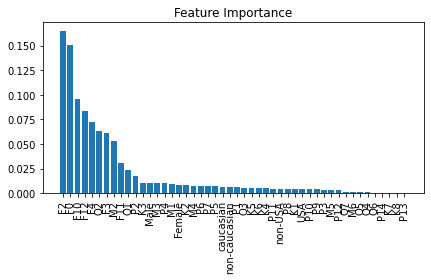

In [91]:
from sklearn.ensemble import RandomForestClassifier
#
# Train the mode
#
forest = RandomForestClassifier()
forest.fit(x_tr_scaled, y_tr.ravel())
importances = forest.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(encoded_df_tr.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(encoded_df_tr.shape[1]), encoded_df_tr.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [101]:
# SERIALIZZAZIONE PIPELINE PER LA ROUTINE DI TEST
import pickle
import dill
import cloudpickle

preprocessor = Pipeline(steps=[('imputer',imputer),('encoder',encoder),('scaler',scaler)])

with open('preprocessor.pkl', 'wb') as out_file:
    dill.dump(preprocessor, out_file)

In [102]:
# BALANCING: oversampling

print(x_tr_scaled.shape)

balancer = KMeansSMOTE(sampling_strategy=1, k_neighbors=5, kmeans_estimator=5)
x_tr_balanced, y_tr_balanced = balancer.fit_resample(x_tr_scaled, y_tr)

print(x_tr_balanced.shape)

(24746, 42)
(37576, 42)


In [103]:
# ANOMALY DETECTION CON ISOLATION FOREST
print("Initial distribution")
print(len(x_tr_balanced))
print(np.unique(y_tr_balanced, return_counts=True)[1]/len(y_tr))

anomaly_detector = IsolationForest(n_estimators = 220, bootstrap = True, random_state = 42)
anomaly_detector.fit(x_tr_balanced)
is_inlier = anomaly_detector.predict(x_tr_balanced)

print(np.unique(is_inlier, return_counts=True))
x_tr_not_anomalous = x_tr_balanced[is_inlier==1,:]
y_tr_not_anomalous = y_tr_balanced[is_inlier==1]

print("Distribution after (balancing and) anomaly detection")
print(len(x_tr_not_anomalous))
print(np.unique(y_tr_not_anomalous, return_counts=True)[1]/len(y_tr_not_anomalous))

Initial distribution
37576
[0.7591934  0.75927423]
(array([-1,  1]), array([ 1924, 35652]))
Distribution after (balancing and) anomaly detection
35652
[0.4934646 0.5065354]


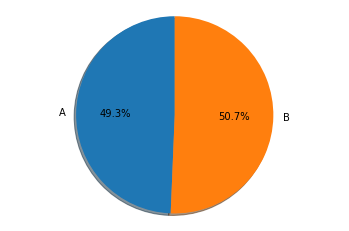

Size del dataset prima del sampler: 35652
Size del dataset dopo il sampler: 35186


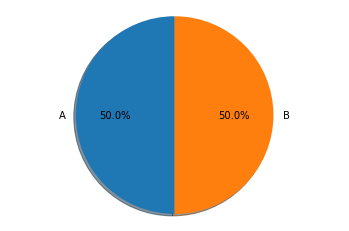

In [104]:
# BALANCING: undersampling

n_classes = len(np.unique(y_tr_not_anomalous))
fig, ax = plt.subplots()
sizes = [len(y_tr_not_anomalous[y_tr_not_anomalous==i]) for i in range(n_classes)]
class_names = [chr(ord('A')+i) for i in range(n_classes)]

ax.pie(sizes, labels=class_names, autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis("equal")
plt.show()

from imblearn.under_sampling import NearMiss
sampler = RandomUnderSampler(sampling_strategy=1)
x_tr_balanced2, y_tr_balanced2 = sampler.fit_resample(x_tr_not_anomalous, y_tr_not_anomalous)

print("Size del dataset prima del sampler: {}".format(x_tr_not_anomalous.shape[0]))
print("Size del dataset dopo il sampler: {}".format(x_tr_balanced2.shape[0]))

fig, ax = plt.subplots()
sizes = [len(y_tr_balanced2[y_tr_balanced2==i]) for i in range(n_classes)]
class_names = [chr(ord('A')+i) for i in range(n_classes)]

ax.pie(sizes, labels=class_names, autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis("equal")
plt.show()

In [30]:
def train_evaluate(model, x_tr, y_tr, x_ts, y_ts):
  model.fit(x_tr, y_tr)
  y_tr_pred = model.predict(x_tr)
  y_ts_pred = model.predict(x_ts)
  print("Accuracy on training set {}".format(accuracy_score(y_tr, y_tr_pred)))
  print("F1 score on training set {}".format(f1_score(y_tr, y_tr_pred)))
  print(confusion_matrix(y_tr, y_tr_pred))
  print("Accuracy on test set {}".format(accuracy_score(y_ts, y_ts_pred)))
  print("F1 score on test set {}".format(f1_score(y_ts, y_ts_pred)))
  print(confusion_matrix(y_ts, y_ts_pred))

In [105]:
# CLASSIFICATION: METODI ENSEMBLE
#print("******* RandomForestClassifier")
#classifier = RandomForestClassifier(max_depth=5, n_estimators=100)
#train_evaluate(classifier, x_tr_not_anomalous, y_tr_not_anomalous, x_ts_scaled, y_ts)

# i classificatori che hanno permesso di ottenere le migliori performance
# sono stati senza dubbio gli alberi, e in particolare il gradient boosting classifier (per ora siamo a: 87,62-87,71/84)

print("******* GradientBoostingClassifier: oversampling + anomaly")
classifier = GradientBoostingClassifier(max_depth=5, n_estimators=220,loss='exponential')
train_evaluate(classifier, x_tr_not_anomalous, y_tr_not_anomalous, x_ts_scaled, y_ts)

print("******* GradientBoostingClassifier: oversampling")
classifier2 = GradientBoostingClassifier(max_depth=5, n_estimators=225,loss='exponential')
train_evaluate(classifier2, x_tr_balanced, y_tr_balanced, x_ts_scaled, y_ts)

print("******* GradientBoostingClassifier: over + under")
classifier3 = GradientBoostingClassifier(max_depth=5, n_estimators=225,loss='exponential')
train_evaluate(classifier3, x_tr_balanced2, y_tr_balanced2, x_ts_scaled, y_ts)

******* GradientBoostingClassifier: oversampling + anomaly
Accuracy on training set 0.9263715920565466
F1 score on training set 0.9258076368672451
[[16649   944]
 [ 1681 16378]]
Accuracy on test set 0.8746001279590531
F1 score on test set 0.7222222222222221
[[5561  372]
 [ 608 1274]]
******* GradientBoostingClassifier: oversampling
Accuracy on training set 0.9275601447732595
F1 score on training set 0.925988362608081
[[17826   961]
 [ 1761 17028]]
Accuracy on test set 0.8767754318618042
F1 score on test set 0.7266534203803577
[[5572  361]
 [ 602 1280]]
******* GradientBoostingClassifier: over + under
Accuracy on training set 0.927158528960382
F1 score on training set 0.9255655911480266
[[16688   905]
 [ 1658 15935]]
Accuracy on test set 0.8761356365962892
F1 score on test set 0.7235865219874358
[[5580  353]
 [ 615 1267]]


In [74]:
dump(classifier2, 'classifier.joblib') 

['classifier.joblib']